# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque
from keras.regularizers import l2, l1, l1_l2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras


from qkeras import *



2022-07-18 10:44:15.184695: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-18 10:44:15.190583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 10:44:15.190597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


In [3]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()


2022-07-18 10:44:19.951382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-18 10:44:19.951418: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-18 10:44:19.951445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-07-18 10:44:19.952433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [4]:
# settings of the networks 
output = 1

nbr_batch =64
nbr_epoch = 200
lr_0=0.01
lr=0.001
lr1=0.0001

delta= 0.00000001


nbr_conv_epoch = 100 #number of epochs for the conversion 
patience_es = 12
patience_es7=7

patience_rlr = 5


def units(j): return (j+8)
units_range = 1

def version(v): return v
versions_range = 10

In [5]:
#quantized settings
integer = 0


def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 7

In [60]:
# path


#path of the tested models 
def models_path0(v) : return f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr0}_mindelta{delta}_v{version(v)}.h5"
def predicts_path0(v) : return f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr0}_mindelta{delta}_v{version(v)}.npy"

def models_path1(v) : return f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v{version(v)}.h5"
def predicts_path1(v) : return f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v{version(v)}.npy"
 
#path of the qconverted models
def qmodels_path(i): return f"tests/qmodels/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>.h5"
def qpredicts_path(i): return f"tests/qpredicts/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>.npy"

#path of the qconverted models
def qhist_path(i): return f"tests/qhist/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>.pkl"

def qmodels_path1(i): return f"tests/qmodels/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)-2},{integer}>v1.h5"
def qpredicts_path1(i): return f"tests/qpredicts/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)-2},{integer}>v1.npy"

#path of the qconverted models
def qhist_path1(i): return f"tests/qhist/qmodels_lr={lr}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)-2},{integer}>v1.pkl"


def qmodels_pathpo2(i): return f"tests/qmodels/qmodels_lr={lr_0}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>po2.h5"
def qpredicts_pathpo2(i): return f"tests/qpredicts/qmodels_lr={lr_0}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>po2.npy"

#path of the qconverted models
def qhist_pathpo2(i): return f"tests/qhist/qmodels_lr={lr_0}_patiencES={patience_es7}_patienceRLR={patience_rlr}_mindelta{delta},homo<{bit_lenghts(i)},{integer}>po2.pkl"


refmodels_path = f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta}_v4.h5"      
refpredicts_path = f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta}_v4.npy"      



## Data creation

In [7]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

xref, xref_val, xref_test, yref, yref_val, yref_test = ds()



shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


# 3. Compare the results

In [12]:
def exist(path, modeltopred):

    if (os.path.exists(path)==False):
        print(path)
        print('saving')
        np.save(path, modeltopred.predict([X_test_past, X_test]))
        print('saved')
    else : print(f'{path} already exists')

In [9]:
ref_path = 'tests/ref_predicts.npy'
exist(ref_path, boosted_model)

tests/ref_predicts.npy already exists


In [10]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

X, X_valid, X_test, y, y_valid, y_test = ds(seq_len=30)

X_past = X[:,:25,:]
X_valid_past = X_valid[:,:25,:]
X_test_past = X_test[:,:25,:]

X = X[:,25:,:]
X_valid = X_valid[:,25:,:]
X_test = X_test[:,25:,:]

shapes (1999970, 30, 1) (1999970, 1)
shapes (899956, 30, 1) (99969, 30, 1) (999985, 30, 1)


## Predictions

### For keras

In [14]:
for v in range (versions_range):

    model0 = tf.keras.models.load_model(models_path0(v))
    exist(predicts_path0(v), model0)


    model1 = tf.keras.models.load_model(models_path1(v))
    exist(predicts_path1(v), model1)

    """model2 = tf.keras.models.load_model(models_path2(v))
    exist(predicts_path2(v), model2)    
   
    model3 = tf.keras.models.load_model(models_path3(v))
    exist(predicts_path3(v), model3)

    model4 = tf.keras.models.load_model(models_path4(v))
    exist(predicts_path4(v), model4)

    model5 = tf.keras.models.load_model(models_path5(v))
    exist(predicts_path5(v), model5)"""
    

NameError: name 'patience_rlr0' is not defined

[8.025029e-06, 1.16410165e-05, 9.775778e-06]
[1.0071724e-05, 9.503524e-06, 9.775778e-06]
[9.675679e-06, 8.342218e-06, 9.775778e-06]
[9.904208e-06, 9.773734e-06, 9.775778e-06]
[9.875098e-06, 7.937658e-06, 9.775778e-06]
[8.192489e-06, 9.769992e-06, 9.775778e-06]
[9.912042e-06, 8.040096e-06, 9.775778e-06]
[8.2267015e-06, 8.1771705e-06, 9.775778e-06]
[1.0046312e-05, 1.01460455e-05, 9.775778e-06]
[1.05566205e-05, 8.405853e-06, 9.775778e-06]


([<matplotlib.axis.XTick at 0x7f687c725210>,
 [Text(0, 0, 'patience rlr = 3'),
  Text(1, 0, 'patience rlr = 5'),
  Text(2, 0, 'ref')])

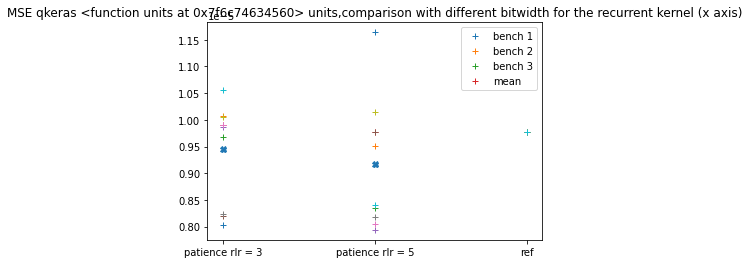

In [ ]:
loss0 = [] 
loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum0=0
sum1=0
sum2=0
sum3=0
sum4=0


yaxis.append('patience rlr = 3')
yaxis.append('patience rlr = 5')
yaxis.append('ref')

for v in range (versions_range):
    loss1 = [] 
    y_keras = np.load(ref_path)
    y_keras0 = np.load(predicts_path0(v))
    y_keras1 = np.load(predicts_path1(v))

    sum0= sum0+mse(y_test,y_keras0)
    sum1= sum1+mse(y_test,y_keras1)
            
    loss1.append(mse(y_test,y_keras0)) 
    loss1.append(mse(y_test,y_keras1)) 
 
    loss1.append(mse(yref_test,y_keras))  
    plt.plot(loss1,'+')
    print(loss1)

loss2.append((sum0/versions_range))
loss2.append((sum1/versions_range))



plt.plot(loss2,'X')
plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'MSE qkeras {units} units,comparison with different bitwidth for the recurrent kernel (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])



### For Qkeras

In [61]:
ref = tf.keras.models.load_model(refmodels_path)
exist(refpredicts_path, ref)
for i in range (bits_range):
    qmodel = qkeras.utils.load_qmodel(qmodels_path(i)) 
    exist(qpredicts_path(i), qmodel) 
    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i)) 
    exist(qpredicts_path1(i), qmodel1) 
    qmodelpo2 = qkeras.utils.load_qmodel(qmodels_pathpo2(i)) 
    exist(qpredicts_pathpo2(i), qmodelpo2) 

tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v4.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<4,0>.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<2,0>v1.npy already exists
tests/qpredicts/qmodels_lr=0.01_patiencES=7_patienceRLR=5_mindelta1e-08,homo<4,0>po2.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<6,0>.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<4,0>v1.npy already exists
tests/qpredicts/qmodels_lr=0.01_patiencES=7_patienceRLR=5_mindelta1e-08,homo<6,0>po2.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<8,0>.npy already exists
tests/qpredicts/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<6,0>v1.npy already exists
tests/qpredicts/qmodels_lr=0.01_patiencES=7_patienceRLR=5_mindelta1e-08,homo<8,0>po2.npy 

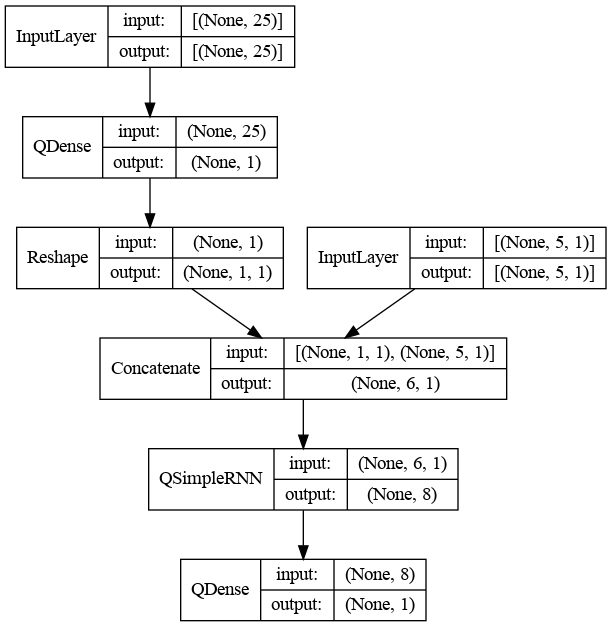

In [16]:
from keras.utils.vis_utils import plot_model

qmodel = qkeras.utils.load_qmodel(qmodels_path(2)) 
plot_model(qmodel,show_shapes=True, show_layer_names=False)

([<matplotlib.axis.XTick at 0x7f8b403dba10>,
 [Text(0, 0, '<6, 0>'),
  Text(1, 0, '<8, 0>'),
  Text(2, 0, '<10, 0>'),
  Text(3, 0, '<12, 0>'),
  Text(4, 0, '<14, 0>')])

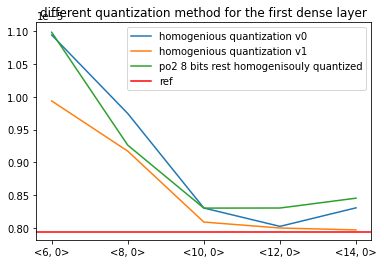

In [63]:
loss0 = []
loss1 = []
loss_8 = []
loss_816 = []
loss_816lr = []
losspo2 = []
loss_8po216 = []
bits = []

for i in range (1,bits_range):
    bits.append(i)
    y_qkeras = np.load(qpredicts_path(i))
    y_qkeras1 = np.load(qpredicts_path1(i))
    y_qkeraspo2 = np.load(qpredicts_pathpo2(i))
   
    
    mse_0=mse(y_test,y_qkeras)
    mse1=mse(y_test,y_qkeras1)
    msepo2=mse(y_test,y_qkeraspo2)

    loss0.append(mse_0)
    loss1.append(mse1)
    losspo2.append(msepo2)

y_ref = np.load(refpredicts_path)


plt.plot(loss0)
plt.plot(loss1)
plt.plot(losspo2)

plt.axhline(mse(y_test, y_ref), color='red')
plt.title ("different quantization method for the first dense layer")
plt.legend(["homogenious quantization v0","homogenious quantization v1","po2 8 bits rest homogenisouly quantized","ref"])
plt.xticks(np.arange(len(bits)), [f"<{bit_lenghts(Bit)}, {integer}>" for Bit in bits])


In [62]:
how_is_the_ntw_quantized(qmodels_path(2))
how_is_the_ntw_quantized(qmodels_path1(2))
how_is_the_ntw_quantized(qmodels_pathpo2(2))


tests/qmodels/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<8,0>.h5
InputLayer is not a quantized layer
QDense
kernel quantized at quantized_bits(8,0,0,alpha=1)
bias quantized at quantized_bits(8,0,0,alpha=1)
Reshape is not a quantized layer
InputLayer is not a quantized layer
Concatenate is not a quantized layer
QSimpleRNN
kernel quantized at quantized_bits(8,0,0,alpha=1)
recurrent kernel quantized at quantized_bits(8,0,0,alpha=1)
bias quantized at quantized_bits(8,0,0,alpha=1)
QDense
kernel quantized at quantized_bits(8,0,0,alpha=1)
bias quantized at quantized_bits(8,0,0,alpha=1)
tests/qmodels/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<6,0>v1.h5
InputLayer is not a quantized layer
QDense
kernel quantized at quantized_bits(8,0,0,alpha=1)
bias quantized at quantized_bits(8,0,0,alpha=1)
Reshape is not a quantized layer
InputLayer is not a quantized layer
Concatenate is not a quantized layer
QSimpleRNN
kernel quantized at quantized_bits(8,0,0,alpha=1)
r

8.833552e-06
8.279987e-06
8.240985e-06
7.99311e-06
8.171813e-06
8.648829e-06


([<matplotlib.axis.XTick at 0x7fb6e8651890>,
 [Text(0, 0, '<4, 0>'),
  Text(1, 0, '<6, 0>'),
  Text(2, 0, '<8, 0>'),
  Text(3, 0, '<10, 0>'),
  Text(4, 0, '<12, 0>'),
  Text(5, 0, '<14, 0>')])

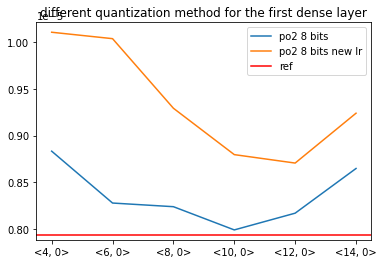

In [26]:
loss0 = []
loss_1 = []
loss_8 = []
loss_816 = []
loss_816lr = []
loss_8po2 = []
loss_8po216 = []
bits = []

for i in range (bits_range):
    bits.append(i)
    y_qkeras = np.load(qpredicts_path0(i))
    y_qkeras_1 = np.load(qpredicts_path1(i))
    y_qkeras_8 = np.load(qpredicts_path8(i))
    y_qkeras_816 = np.load(qpredicts_path816(i))
    y_qkeras_816lr = np.load(qpredicts_path816lr(i))
    y_qkeras_8po2 = np.load(qpredicts_path8po2(i))
    y_qkeras_8po216 = np.load(qpredicts_path8po216(i))
    
    mse_0=mse(y_test,y_qkeras)
    mse_1=mse(y_test, y_qkeras_1)
    mse_8=mse(y_test, y_qkeras_8)
    mse_816=mse(y_test, y_qkeras_816)
    mse_816lr=mse(y_test, y_qkeras_816lr)
    mse_8po2=mse(y_test, y_qkeras_8po2)
    mse_8po216=mse(y_test, y_qkeras_8po216)

    print(mse_1)
    loss0.append(mse_0)
    loss_1.append(mse_1)
    loss_8.append(mse_8)
    loss_816.append(mse_816)
    loss_816lr.append(mse_816lr)
    loss_8po2.append(mse_8po2)
    loss_8po216.append(mse_8po216)
y_ref = np.load(refpredicts_path)



plt.plot(loss_1)
plt.plot(loss_8)

plt.axhline(mse(y_test, y_ref), color='red')
plt.title ("different quantization method for the first dense layer")
plt.legend(["po2 8 bits lr=0.001","po2 8 bits new lr=0.0001","ref"])
plt.xticks(np.arange(len(bits)), [f"<{bit_lenghts(Bit)}, {integer}>" for Bit in bits])


In [51]:

print(qkeras.utils.load_qmodel(qmodels_path816(1)).layers[1].get_weights().__class__.__name__)
print(qkeras.utils.load_qmodel(qmodels_path816(1)).layers[0])
print(qkeras.utils.load_qmodel(qmodels_path1(1)).layers[5].trainable_weights)




list
[<tf.Variable 'q_simple_rnn_2/q_simple_rnn_cell_80/kernel:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.85563105,  0.97818077,  0.11628012, -0.98994124,  0.02537058,
        -0.7441219 ,  0.9965217 ,  0.99983513]], dtype=float32)>, <tf.Variable 'q_simple_rnn_2/q_simple_rnn_cell_80/recurrent_kernel:0' shape=(8, 8) dtype=float32, numpy=
array([[-0.47361082,  0.01154891, -0.2566416 ,  0.4661046 , -0.17204584,
        -0.07000595,  0.41607985, -0.6269327 ],
       [-0.87256813,  0.1512048 , -0.04514315,  0.04892032, -0.19035427,
         0.49098548, -0.47907358, -0.93871796],
       [ 0.12050079,  0.23653476, -0.99413073, -0.6382317 ,  0.37202403,
         0.30839428, -0.8367543 , -0.982762  ],
       [-0.47523263, -0.46908665,  0.15920642, -0.03316   ,  0.10257115,
         0.18201731, -0.29008526,  0.62527597],
       [ 0.21661107,  0.11625806, -0.29094452,  0.4707942 , -0.12271184,
         0.2816476 , -0.485691  , -0.17656231],
       [-0.14188464,  0.48530778, -0.4752702 ,  0.

In [65]:
REGISTERED_LAYERS = ["Dense", "Conv1D", "Conv2D", "DepthwiseConv2D",
                     "SimpleRNN", "LSTM", "GRU", "Bidirectional",
                     "Conv2DTranspose", "SeparableConv1D", "SeparableConv2D"]

Q_LAYERS = list(map(lambda x : 'Q' + x, REGISTERED_LAYERS))

print (Q_LAYERS)

def how_is_the_ntw_quantized (the_network_path):
    print(the_network_path)
    the_network = qkeras.utils.load_qmodel(the_network_path)
     
    for i in range (len(the_network.layers)):
        layer_type=the_network.layers[i].__class__.__name__
        if(layer_type in Q_LAYERS):
            print(f"{the_network.layers[i].__class__.__name__}")                                         
            if (len(the_network.layers[i].get_quantizers())==4):
                print(f"kernel quantized at {the_network.layers[i].get_quantizers()[0]}")                
                print(f"recurrent kernel quantized at {the_network.layers[i].get_quantizers()[1]}")
                print(f"bias quantized at {the_network.layers[i].get_quantizers()[2]}")
            
            if (len(the_network.layers[i].get_quantizers())==2):
                print(f"kernel quantized at {the_network.layers[i].get_quantizers()[0]}")                
                print(f"bias quantized at {the_network.layers[i].get_quantizers()[1]}")
        else : print(f"{layer_type} is not a quantized layer")
                
how_is_the_ntw_quantized(qmodels_path(0))

['QDense', 'QConv1D', 'QConv2D', 'QDepthwiseConv2D', 'QSimpleRNN', 'QLSTM', 'QGRU', 'QBidirectional', 'QConv2DTranspose', 'QSeparableConv1D', 'QSeparableConv2D']
tests/qmodels/qmodels_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,homo<4,0>.h5
InputLayer is not a quantized layer
QDense
kernel quantized at quantized_bits(4,0,0,alpha=1)
bias quantized at quantized_bits(4,0,0,alpha=1)
Reshape is not a quantized layer
InputLayer is not a quantized layer
Concatenate is not a quantized layer
QSimpleRNN
kernel quantized at quantized_bits(4,0,0,alpha=1)
recurrent kernel quantized at quantized_bits(4,0,0,alpha=1)
bias quantized at quantized_bits(4,0,0,alpha=1)
state quantizer quantized at None
QDense
kernel quantized at quantized_bits(4,0,0,alpha=1)
bias quantized at quantized_bits(4,0,0,alpha=1)


In [20]:
for v in range (versions_range):
    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    print('rest:<8,0>, rkernel<8.0>',mse(y_test,y_qkeras1))
for v in range (versions_range):
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    print('rest:<8,0>, rkernel<6.0>',mse(y_test,y_qkeras2))
for v in range (versions_range):
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    print('rest:<8,0>, rkernel<4.0>',mse(y_test,y_qkeras3))  
for v in range (versions_range):
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    print('rest:<8,0>, rkernel<2.0>',mse(y_test,y_qkeras4))    


NameError: name 'qtrained_predicts_path' is not defined

In [ ]:
qkeras.__version__


'0.9.0'

[1.1981933e-05, 1.2034845e-05, 1.093289e-05, 1.1920184e-05, 1.9061952e-05, 9.775778e-06]
[1.2803593e-05, 1.2831303e-05, 1.17863065e-05, 1.0700691e-05, 1.9061952e-05, 9.775778e-06]
[1.3187369e-05, 1.2641142e-05, 1.1027703e-05, 1.1706385e-05, 1.9061952e-05, 9.775778e-06]
[1.1874639e-05, 1.3375705e-05, 1.2063947e-05, 1.2289292e-05, 1.9061952e-05, 9.775778e-06]
[1.1662366e-05, 1.20250825e-05, 1.2980661e-05, 1.2464392e-05, 1.9061952e-05, 9.775778e-06]
[1.2207298e-05, 1.351107e-05, 1.1895124e-05, 1.1532051e-05, 1.9061952e-05, 9.775778e-06]
[1.2393877e-05, 1.3170795e-05, 1.3478827e-05, 1.2416229e-05, 1.9061952e-05, 9.775778e-06]
[1.26406385e-05, 1.1713331e-05, 1.3042967e-05, 1.12773505e-05, 1.9061952e-05, 9.775778e-06]
[1.1121343e-05, 1.36477265e-05, 1.2054673e-05, 1.353617e-05, 1.9061952e-05, 9.775778e-06]
[1.1481197e-05, 1.2520866e-05, 1.2609797e-05, 1.2789157e-05, 1.9061952e-05, 9.775778e-06]


([<matplotlib.axis.XTick at 0x7f54a47ddd90>,
 [Text(0, 0, '<2,0>'),
  Text(1, 0, '<4,0>'),
  Text(2, 0, '<6,0>'),
  Text(3, 0, '<8,0>'),
  Text(4, 0, 'qref'),
  Text(5, 0, 'ref')])

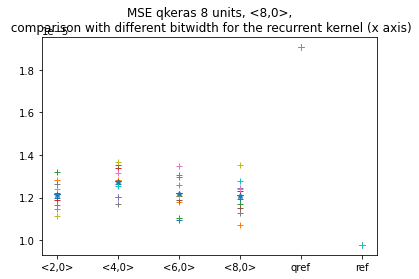

In [ ]:

loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
j=0
i=0
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('qref')
yaxis.append('ref')

for v in range (versions_range):
    loss1 = [] 
    y_qkeras5 = np.load(qrefpredicts_path(i))
    y_keras = np.load(ref_path)

    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    sum1= sum1+mse(y_test,y_qkeras1)
    sum2= sum2+mse(y_test,y_qkeras2)
    sum3= sum3+mse(y_test,y_qkeras3)
    sum4= sum4+mse(y_test,y_qkeras4)
    loss1.append(mse(y_test,y_qkeras4)) 
    loss1.append(mse(y_test,y_qkeras3)) 
    loss1.append(mse(y_test,y_qkeras2))          
    loss1.append(mse(y_test,y_qkeras1)) 
    loss1.append(mse(y_test,y_qkeras5))  
    loss1.append(mse(y_test,y_keras))  
    plt.plot(loss1,'+')
    print(loss1)
loss2.append((sum4/10))
loss2.append((sum3/10))
loss2.append((sum2/10))
loss2.append((sum1/10))



plt.plot(loss2,'*')
#plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'MSE qkeras {units(j)} units, <{bit_lenghts(i)},{integer}>,\n comparison with different bitwidth for the recurrent kernel (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])



[1.3366514e-05, 1.4818796e-05, 1.49605685e-05, 1.4570147e-05, 9.775778e-06]
[1.4368032e-05, 1.38080795e-05, 1.4608886e-05, 1.4171368e-05, 9.775778e-06]
[1.3569032e-05, 1.371929e-05, 1.468703e-05, 1.38025725e-05, 9.775778e-06]


([<matplotlib.axis.XTick at 0x7f37e41edc10>,
 [Text(0, 0, 'set4'),
  Text(1, 0, 'set3'),
  Text(2, 0, 'set2'),
  Text(3, 0, 'set1'),
  Text(4, 0, 'ref')])

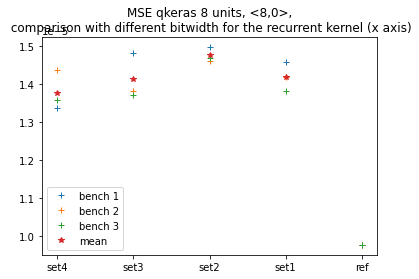

In [ ]:
loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
j=0
i=0

yaxis.append('set4')
yaxis.append('set3')
yaxis.append('set2')
yaxis.append('set1')

#yaxis.append('qref')
yaxis.append('ref')

for v in range (versions_range):
    loss1 = [] 
    y_qkeras5 = np.load(qrefpredicts_path(i))
    y_keras = np.load(ref_path)

    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    sum1= sum1+mse(y_test,y_qkeras1)
    sum2= sum2+mse(y_test,y_qkeras2)
    sum3= sum3+mse(y_test,y_qkeras3)
    sum4= sum4+mse(y_test,y_qkeras4)
    loss1.append(mse(y_test,y_qkeras4)) 
    loss1.append(mse(y_test,y_qkeras3)) 
    loss1.append(mse(y_test,y_qkeras2))          
    loss1.append(mse(y_test,y_qkeras1)) 
    #loss1.append(mse(y_test,y_qkeras5))  
    loss1.append(mse(y_test,y_keras))  
    plt.plot(loss1,'+')
    print(loss1)
loss2.append((sum4/3))
loss2.append((sum3/3))
loss2.append((sum2/3))
loss2.append((sum1/3))



plt.plot(loss2,'*')
plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'MSE qkeras {units(j)} units, <{bit_lenghts(i)},{integer}>,\n comparison with different bitwidth for the recurrent kernel (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])



## Plotting

### Keras

In [ ]:

y_keras4 = np.load(ref_path)
loss1 = [] 
loss2 = []
loss3 = []
loss4 = []   
unit_nbr=[]
for j in range(units_range):
    y_keras1 = np.load(predicts_path1(j))

    y_keras1 = np.load(predicts_path1(j))


    unit_nbr.append(f'{units(j)}')
    
    loss1.append(mse(y_test,y_keras1))        
    loss2.append(mse(y_test,y_keras2))
    loss3.append(mse(y_test,y_keras3))
    loss4.append(mse(y_test,y_keras4))

plt.figure()
plt.subplot()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.plot(loss4)

plt.legend(['delta = 0.00000001','delta = 0.0000001','delta = 0.0001','ref'])
plt.xticks(np.arange(len(unit_nbr)), [f"{Bit}" for Bit in unit_nbr])
plt.xlabel('units settings')
plt.yscale('log')
plt.ylabel('MSE')
plt.title(f'MSE keras X units, comparison with different min delta\n patience early stopping = {patience_es}, patiences reduce lr {patience_rlr}')
plt.show()

TypeError: predicts_path1() missing 1 required positional argument: 'v'

### qkeras

qpredicts_epoch=4/qpredicts<4,0>.npy
qpredicts_epoch=4/qpredicts<6,0>.npy
qpredicts_epoch=4/qpredicts<8,0>.npy
qpredicts_epoch=4/qpredicts<10,0>.npy
qpredicts_epoch=4/qpredicts<12,0>.npy


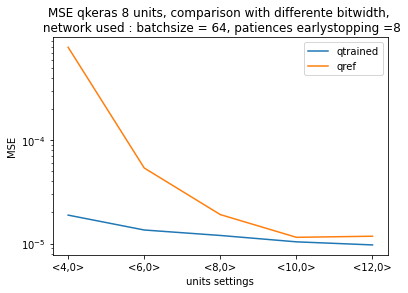

In [ ]:

unit_nbr = []
for v in range (units_range):
    unit_nbr.append(f'{units(j)}')

    loss1 = [] 
    loss2 = []
    loss3 = []
    loss4 = []  
    bit_nbr = []
    for i in range(bits_range):
        print(qrefpredicts_path(i))
        y_keras4 = np.load(qrefpredicts_path(i))
        bit_nbr.append(bit_lenghts(i))
        y_qkeras1 = np.load(qtrained_predicts_path(j,i))
        #y_qkeras2 = np.load(qpredicts_path2(j,i))

        
        loss1.append(mse(y_test,y_qkeras1))        
        #loss2.append(mse(y_test,y_qkeras2))
        loss4.append(mse(y_test,y_keras4))

    plt.figure()
    plt.subplot()
    plt.plot(loss1)
    plt.plot(loss4)

    plt.legend(['qtrained','qref'])
    plt.xticks(np.arange(len(bit_nbr)), [f"<{Bit},{integer}>" for Bit in bit_nbr])
    plt.xlabel('units settings')
    plt.yscale('log')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras {units(j)} units, comparison with differente bitwidth, \n network used : batchsize = {nbr_batch}, patiences earlystopping =8')
plt.show()

In [ ]:
print(mse(y_test,y_keras4))

9.775778e-06


In [ ]:
import ROOT

Welcome to JupyROOT 6.26/02


In [ ]:
import importlib
import nnDumper_standalone
importlib.reload(nnDumper_standalone)
#_,_, X_test,_,_,y_test = ds()

m_t = 16

dump_preds = nnDumper_standalone.dumper(start = 999997, name = "pulse_noise_15p", bt_len=80)

dump_preds.set_data(true = ds.hit, data = ds.dig, sig = ds.sig, ofmax = ds.ofmax)

#dump_preds.set_preds('rnn_seq5', m_t*rnn8_model.predict(X_test).flatten())
#dump_preds.set_preds('lstm_seq5', m_t*lstm_u10_model.predict(X_test).flatten())
#dump_preds.set_preds('lstm_no_dense', m_t*rnn8_model.predict(X_test).flatten())
dump_preds.set_preds('rnn_seq5', m_t*vanilla_sliding_psp8ns_model.predict(X_test).flatten())

dump_preds.runme()

ModuleNotFoundError: No module named 'nnDumper_standalone'